# King County Housing Data

The King Count Housing dataset contains information about houses in King County Washington. We're going to use it to see if we can predict the future house sale values.

We'll start by loading all of the necessary packages:

In [4]:
#Importing some necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
import seaborn as sns 

In [5]:
# warnings get old after awhile
warnings.filterwarnings(action='ignore')

### Data cleaning

To make data cleaning easy, we've defined some functions.

In [6]:
# A function that allows us to drop rows based on values we think are suspect

def drop_rows(df, colname, val):
    return df[df[colname] != val]

In [7]:
# A function to take columns with years (yr_built, yr_renovated) and bin them by decade

from sklearn.preprocessing import LabelEncoder

def bin_by_decade(df, colname):
    bins = pd.IntervalIndex.from_tuples([(1900, 1909), (1910, 1919), (1920, 1929), (1930, 1939), (1940, 1949), (1950, 1959), (1960, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2010), (2010, 2020)])
    series = pd.cut(df[colname], bins)
    df[colname] = series
    return df

a writen description of variables in normal english



another note -

- what can you move to a separate .py file and import in?

In [8]:
# Contains all of our data cleaning operations

def clean():
    
# Load the data
    
    house = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-dc-ds-career-042219/master/kc_house_data.csv')
    
# Get rid of rows
    # The row with 33 bedrooms is a suspicious outlier, so we decided to drop it
    # The 454 ?s in sqft_basement needed to be remedied. We chose to drop them. 

    clean_house = drop_rows(house, 'bedrooms', 33)
    clean_house = drop_rows(clean_house,'sqft_basement', "?")
    
# Bin decades
    
    clean_house = bin_by_decade(clean_house, 'yr_built')
    clean_house = bin_by_decade(clean_house, 'yr_renovated')
    
    
# Get dummies
    # Note: Originally, we dropped waterfront because it had a lot of null values. Get dummies gives you the option to create a dummy for nulls or not.
    # We did that, without the null column
    clean_house = pd.get_dummies(clean_house, columns=(['waterfront', 'view', 'floors', 'bedrooms', 'bathrooms','condition', 'grade','zipcode', 'yr_built', 'yr_renovated']))
    
# Drop id, date

    clean_house = clean_house.drop(['id', 'date'], axis=1)
    
# Convert sqft_basement from object to float

    clean_house['sqft_basement'] = clean_house['sqft_basement'].astype(float, inplace=True)

# Return clean_house
    
    return clean_house

### Check out this beautiful data!

In [9]:
house = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-dc-ds-career-042219/master/kc_house_data.csv')

In [10]:
clean_house = clean()
clean_house.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,waterfront_0.0,...,"yr_renovated_(1920, 1929]","yr_renovated_(1930, 1939]","yr_renovated_(1940, 1949]","yr_renovated_(1950, 1959]","yr_renovated_(1960, 1969]","yr_renovated_(1970, 1979]","yr_renovated_(1980, 1989]","yr_renovated_(1990, 1999]","yr_renovated_(2000, 2010]","yr_renovated_(2010, 2020]"
0,221900.0,1180,5650,1180,0.0,47.5112,-122.257,1340,5650,0,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,2570,7242,2170,400.0,47.7210,-122.319,1690,7639,1,...,0,0,0,0,0,0,0,1,0,0
2,180000.0,770,10000,770,0.0,47.7379,-122.233,2720,8062,1,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,1960,5000,1050,910.0,47.5208,-122.393,1360,5000,1,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,1680,8080,1680,0.0,47.6168,-122.045,1800,7503,1,...,0,0,0,0,0,0,0,0,0,0


- also you are on the right track with asking about each output "does this need to be shown?"

In [11]:
clean_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21142 entries, 0 to 21596
Columns: 172 entries, price to yr_renovated_(2010, 2020]
dtypes: float64(4), int64(5), uint8(163)
memory usage: 4.9 MB


Please add more of a narrative about why the heat map is there

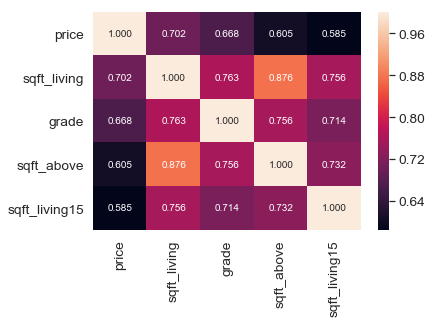

In [12]:
# Checking the distributions of the features relative to our target: price
# Annotated heatmap to associate values to the variables
# Since we used a selection algorithm below, it's important to note highly correlated features in interpreting the coefficients in our model.


corrmat = house.corr()
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(house[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm,annot=True, fmt='.3f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()



### We'd like to know: Where are the most and least expensive houses located?

- can you use gmap? or something where I can see how seattle is there in background?
- or just show a seattle map next to it?? so we know - oh, THERE is the water.

<Figure size 360x360 with 0 Axes>

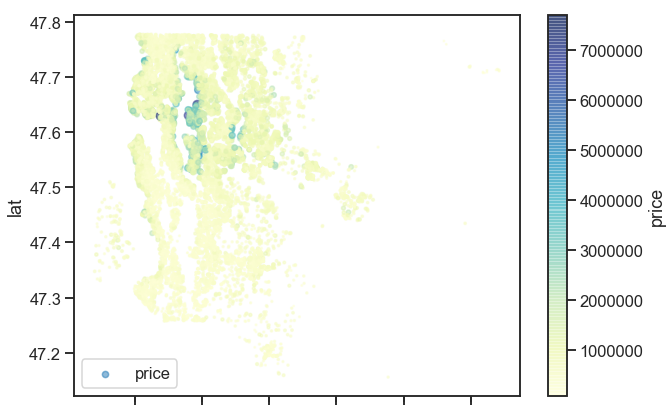

In [55]:
sns.set_context('talk')
fig2 = plt.figure(figsize=(5,5))
plt.tight_layout()

ax3 = house.plot(kind='scatter', x='long', y='lat', s=house['price']/100000, label="price", c="price", cmap=plt.get_cmap("YlGnBu"), colorbar=True, alpha=0.5, figsize=(10,7))
ax3.set_xticklabels([-122.5, -122.2 -121.9 -121.6, -121.3])
sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 20
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
# fig2.savefig('map')

It looks like the high priced homes tend to be in the northwestern part of the county.

 - if you want to show this - why re you showing it? to justify why you are keeping zip code in the model? a proxy for income? because you see a lot of variance by zip code and price - so you think it's important to keep it?
 
 - look at changing color theme in sns
 
 - anytime I see price on an axis - it would be nice to have a $ near it

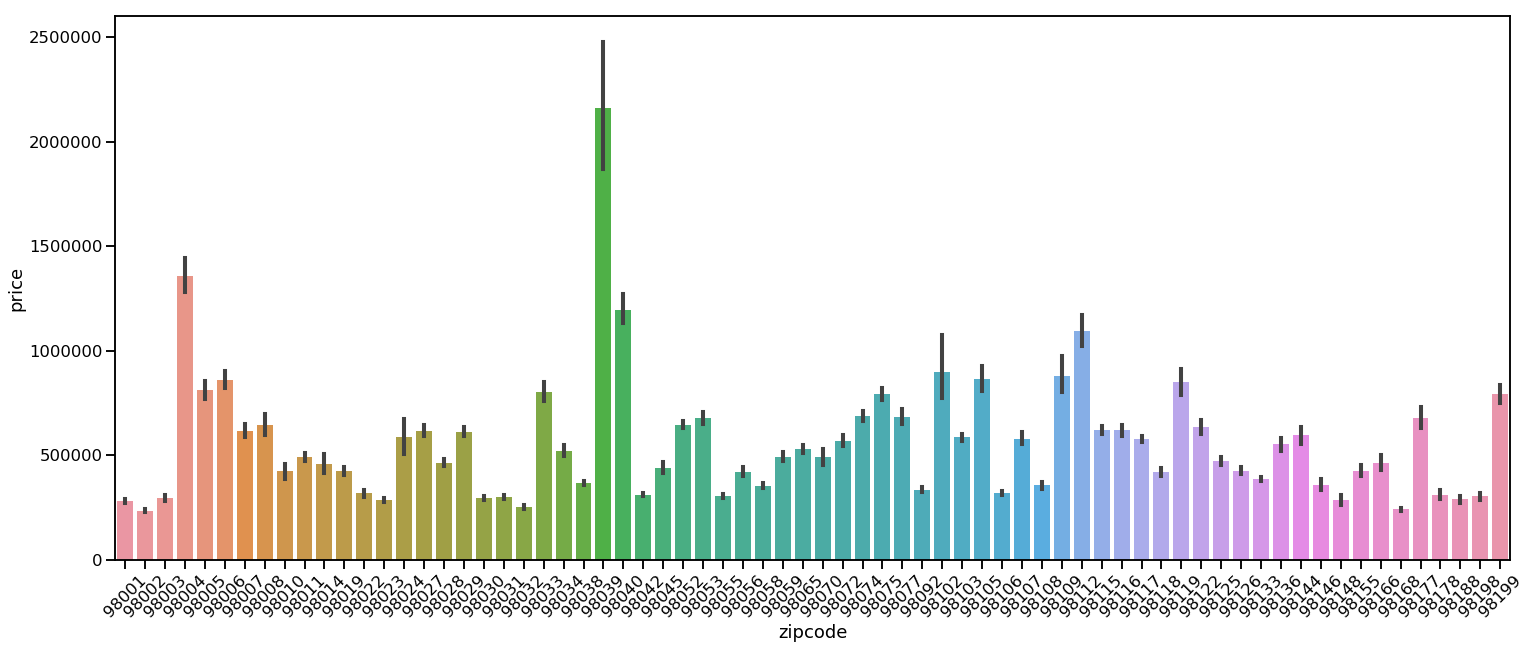

In [8]:
# This plot shows the house price central tendency by zipcode

sns.set_context('talk')
fig = plt.figure(figsize=(25,10))
plt.tight_layout()

ax1 = sns.barplot(x='zipcode', y='price', data=house)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
# fig.savefig("zipcodes")

### Another Question we had was: What's the best time of year to sell your house?


In [13]:
house['month'] = house['date'].apply(lambda i: i[:2])
house['month'] = house['month'].apply(lambda i: i.replace("/", ""))
house['month'].astype(int)


0        10
1        12
2         2
3        12
4         2
5         5
6         6
7         1
8         4
9         3
10        4
11        5
12        5
13       10
14        3
15        1
16        7
17        5
18       12
19        4
20        5
21        8
22        7
23        5
24       11
25       11
26        6
27       12
28        6
29        3
         ..
21567     6
21568    12
21569     8
21570    10
21571     3
21572    11
21573     9
21574     5
21575    10
21576     4
21577     3
21578    10
21579    10
21580     8
21581     4
21582    10
21583     9
21584    10
21585     4
21586     6
21587     8
21588     1
21589    10
21590     3
21591     2
21592     5
21593     2
21594     6
21595     1
21596    10
Name: month, Length: 21597, dtype: int64

In [14]:
#get the average price of houses grouped by month
avgsalesbymonth = house.groupby('month')['price'].mean()
avgsalesbymonth


month
1     525963.251534
10    539439.447228
11    522359.903478
12    524799.902041
2     508520.051323
3     544057.683200
4     562215.615074
5     550849.746893
6     557534.318182
7     544892.161013
8     536655.212481
9     529723.517787
Name: price, dtype: float64

In [15]:
#get the total number of houses sold by month
avgcountsbymonth = house['month'].value_counts()
avgcountsbymonth

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: month, dtype: int64

In [16]:
#make the average sales by month a dataframe so that it can be sorted
df = avgsalesbymonth
df = df.reset_index()
df['month'] = df['month'].astype(int)
df = df.sort_values(by = 'month').reset_index(drop=True)
df

,month,price
0,1,525963.251534
1,2,508520.051323
2,3,544057.683200
3,4,562215.615074
4,5,550849.746893
5,6,557534.318182
6,7,544892.161013
7,8,536655.212481
8,9,529723.517787
9,10,539439.447228


In [17]:
#rename the index of the dataframe
average_sale = df.rename(index = {0:'January',1:'February',2:'March',3:'April',4:'May',5:'June',6:'July',7:'August',
            8:'September',9:'October',10:'November',11:'December'})
average_sale

,month,price
January,1,525963.251534
February,2,508520.051323
March,3,544057.683200
April,4,562215.615074
May,5,550849.746893
June,6,557534.318182
July,7,544892.161013
August,8,536655.212481
September,9,529723.517787
October,10,539439.447228


In [18]:
#drop the month column
average_sale = average_sale.drop(columns = 'month')
average_sale

,price
January,525963.251534
February,508520.051323
March,544057.683200
April,562215.615074
May,550849.746893
June,557534.318182
July,544892.161013
August,536655.212481
September,529723.517787
October,539439.447228


Text(0, 0.5, 'Price ($)')

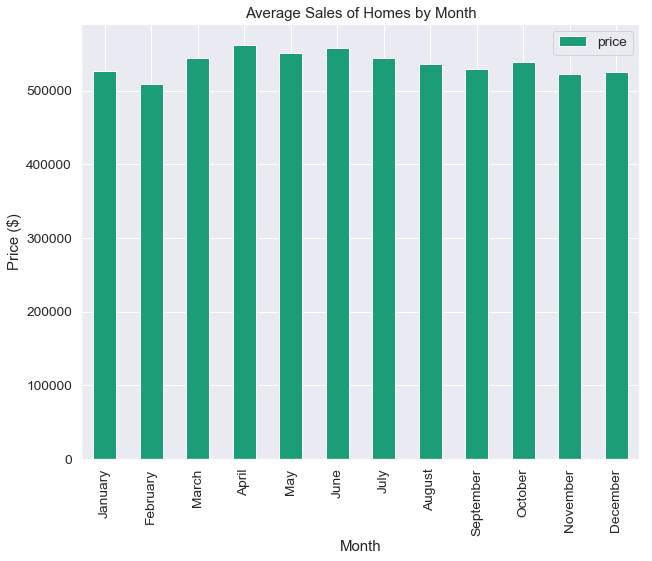

In [19]:
#plot of average prices by month
average_sale.plot(y ='price', use_index=True, figsize = (10,8), kind = 'bar', colormap='Dark2',
                  title = 'Average Sales of Homes by Month')
plt.xlabel('Month')
plt.ylabel('Price ($)')

In [20]:
#make the average counts by month a dataframe so that it can be sorted
df2 = avgcountsbymonth
df2 = df2.reset_index()
df2['index'] = df2['index'].astype(int)
df2 = df2.sort_values(by = 'index').reset_index(drop=True)
df2

,index,month
0,1,978
1,2,1247
2,3,1875
3,4,2229
4,5,2414
5,6,2178
6,7,2211
7,8,1939
8,9,1771
9,10,1876


In [21]:
#rename the index of the dataframe
average_count = df2.rename(index = {0:'January',1:'February',2:'March',3:'April',4:'May',5:'June',
                    6:'July',7:'August',8:'September',9:'October',10:'November',11:'December'})
average_count

,index,month
January,1,978
February,2,1247
March,3,1875
April,4,2229
May,5,2414
June,6,2178
July,7,2211
August,8,1939
September,9,1771
October,10,1876


Text(0, 0.5, 'Count')

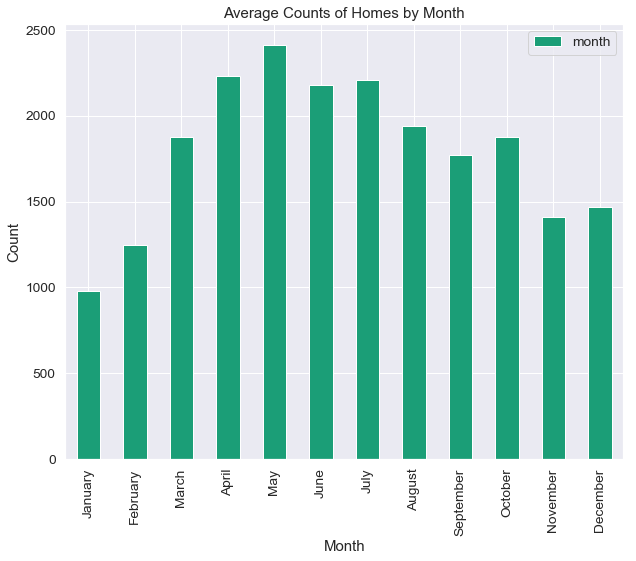

In [22]:
#plot of average counts by month
average_count.plot(y = 'month', use_index= True, figsize = (10,8), kind = 'bar', 
                      colormap='Dark2', title = 'Average Counts of Homes by Month')
plt.xlabel('Month')
plt.ylabel('Count')

- look for the subplot capability
- okay, more houses SELL in May, but the average price per house that is sold per month doesn't differ that much

### Feature selection

Before we built our prediction model, we needed to select the best features. We could make our best estimate of the right combination of features, but there are so many to choose from! With this many features, it's best to use an algorith that takes out the guesswork. 


```
Might want to talk about overfitting vs underfitting - you could throw EVERYTHING in the model, but then you'd be overfitting... so how to you manage that. 



Also put somewhere about the downsides of stepwise feature selection - it's greedy and only looks for p-values. - no real cut off of variables.
```


We found this handy tepwise selection function on Flatiron's learning platform, learn.co. It chooses the features with the lowest p values to use in our model

In [9]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

Here, we took the resulting list of features and used it to create a new dataframe.

In [10]:
clean_house_selections_list = ['price', 'sqft_living', 'view_4.0', 'lat', 'zipcode_98004', 'zipcode_98039', 'zipcode_98112', 'zipcode_98040', 'view_0.0', 'grade_12', 'grade_13', 'grade_11', 'grade_10', 'waterfront_1.0', 'grade_9', 'zipcode_98105', 'zipcode_98119', 'condition_5', 'zipcode_98109', 'zipcode_98199', 'zipcode_98155', 'zipcode_98102', 'zipcode_98122', 'zipcode_98033', 'zipcode_98103', 'zipcode_98115', 'zipcode_98117', 'zipcode_98116', 'zipcode_98006', 'zipcode_98107', 'zipcode_98144', 'zipcode_98005', 'zipcode_98136', 'zipcode_98008', 'yr_renovated_(2000, 2010]', 'bathrooms_7.75', 'zipcode_98029', 'zipcode_98052', 'sqft_basement', 'sqft_above', 'condition_4', 'bathrooms_8.0', 'view_3.0', 'zipcode_98027', 'zipcode_98126', 'zipcode_98007', 'bathrooms_6.0', 'sqft_living15', 'zipcode_98118', 'bathrooms_4.75', 'yr_built_(2010, 2020]', 'zipcode_98019', 'sqft_lot', 'zipcode_98077', 'zipcode_98028', 'floors_3.0', 'grade_8', 'floors_2.0', 'bedrooms_3', 'bathrooms_4.25', 'zipcode_98011', 'bathrooms_3.25', 'yr_renovated_(2010, 2020]', 'zipcode_98014', 'zipcode_98072', 'zipcode_98133', 'zipcode_98022', 'zipcode_98178', 'bathrooms_3.75', 'bathrooms_4.5', 'bedrooms_7', 'bathrooms_4.0', 'bathrooms_5.5', 'bathrooms_5.25', 'bathrooms_5.0', 'bathrooms_6.25', 'yr_renovated_(1990, 1999]', 'zipcode_98010', 'yr_built_(1930, 1939]', 'zipcode_98075', 'zipcode_98038', 'bedrooms_6', 'floors_2.5', 'bathrooms_5.75', 'bedrooms_10', 'zipcode_98168', 'bedrooms_9', 'bedrooms_5', 'condition_1', 'yr_built_(1920, 1929]', 'zipcode_98074', 'zipcode_98053', 'sqft_lot15', 'zipcode_98106', 'bathrooms_2.25', 'zipcode_98198', 'zipcode_98058', 'bathrooms_1.0', 'bathrooms_3.0']
print("The number of features used in the model is:", len(clean_house_selections_list)-1)

# Made a new DF with just the features from our selections list
clean_house_selections = clean_house[clean_house_selections_list]


The number of features used in the model is: 98


### Model with Statsmodels OLS

We fit our data to an ordinary least squares regression model. OLS gives us a handy summary of the results.



In [11]:
y = clean_house["price"]
X = clean_house.drop(['price'], axis=1)

predictors_int = sm.add_constant(X)
model = sm.OLS(y, predictors_int).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     706.3
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        08:26:08   Log-Likelihood:            -2.8130e+05
No. Observations:               21142   AIC:                         5.629e+05
Df Residuals:                   20980   BIC:                         5.642e+05
Df Model:                         161                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -2.166e+07   3.56e+06     -6.083      0.000   -2.86e+07   -1.47e+07
sqft_living                  88.7138      1.761     50.384      0.000      85.263      92.165
sqft_lot                      0.2521      0.036      7.067      0.000       0.182       0.322
sqft_above                   66.4054      1.873     35.455      0.000      62.734      70.076
sqft_basement                22.4268      2.064     10.863      0.000      18.380      26.473
lat                        2.225e+05   5.83e+04      3.816      0.000    1.08e+05    3.37e+05
long                      -2.016e+05   4.23e+04     -4.768      0.000   -2.84e+05   -1.19e+05
sqft_living15                23.4497      2.718      8.628      0.000      18.123      28.777
sqft_lot15                   -0.1520      0.056     -2.698      0.007      -0.262      -0.042
waterfront_0.0              596.9444   3209.731      0.186      0.852   -5694.376    6888.265
waterfront_1.0             6.066e+05   1.56e+04     38.998      0.000    5.76e+05    6.37e+05
view_0.0                  -4.801e+04   1.88e+04     -2.555      0.011   -8.48e+04   -1.12e+04
view_1.0                   4.254e+04   2.05e+04      2.079      0.038    2437.489    8.26e+04
view_2.0                   2.685e+04   1.94e+04      1.385      0.166   -1.11e+04    6.48e+04
view_3.0                   1.042e+05   1.99e+04      5.228      0.000    6.51e+04    1.43e+05
view_4.0                   2.455e+05   2.14e+04     11.485      0.000    2.04e+05    2.87e+05
floors_1.0                -3.598e+06   5.93e+05     -6.062      0.000   -4.76e+06   -2.43e+06
floors_1.5                -3.611e+06   5.93e+05     -6.086      0.000   -4.77e+06   -2.45e+06
floors_2.0                 -3.63e+06   5.93e+05     -6.117      0.000   -4.79e+06   -2.47e+06
floors_2.5                -3.559e+06   5.93e+05     -5.998      0.000   -4.72e+06    -2.4e+06
floors_3.0                -3.683e+06   5.94e+05     -6.206      0.000   -4.85e+06   -2.52e+06
floors_3.5                -3.576e+06   5.95e+05     -6.006      0.000   -4.74e+06   -2.41e+06
bedrooms_1                -1.898e+06   3.24e+05     -5.855      0.000   -2.53e+06   -1.26e+06
bedrooms_2                -1.891e+06   3.24e+05     -5.836      0.000   -2.53e+06   -1.26e+06
bedrooms_3                 -1.88e+06   3.24e+05     -5.801      0.000   -2.52e+06   -1.24e+06
bedrooms_4                -1.895e+06   3.24e+05     -5.848      0.000   -2.53e+06   -1.26e+06
bedrooms_5                -1.909e+06   3.24e+05     -5.892      0.000   -2.54e+06   -1.27e+06
bedrooms_6                -1.934e+06   3.24e+05     -5.968      0.000   -2.57e+06    -1.3e+06
bedrooms_7                -2.072e+06   3.25e+05     -6.382      0.000   -2.71e+06   -1.44e+06
bedrooms_8                -1.936e+06   3.26e+05     -5.932      0.000   -2.

### Can we make a better model with Lasso?

Lasso helps prevent overfitting by reducing the influence of some of the predictors by penalizing their coefficients or reducing them to zero (effectively doing predictor selection). 

To use Lasso, it's best to standardize your data to make sure we get the best results. We used We used Scikit Learn's Standard Scaler, which takes each data point, subtracts the mean of the sample, then divides by the standard deviation of the sample.




In [12]:
clean_house_predictors = clean_house.drop(["price"], axis=1)

ss_scaler = preprocessing.StandardScaler()
clean_house_ss = ss_scaler.fit_transform(clean_house_predictors)

# Standard scaler returns a numpy array, so we converted it back to a data frame.

clean_house_ss = pd.DataFrame(clean_house_ss, columns=list(clean_house_predictors.columns))

In [13]:
# Split the standardized data into train and test sets, this time using all of the columns from clean_house

y = clean_house["price"]
X = clean_house_ss

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=3)
print(len(X_test), len(X_train), len(y_test), len(y_train))

4229 16913 4229 16913


In [14]:
# Fit the data to Lasso

y = clean_house["price"]
X = clean_house_ss

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=3)

lasso = Lasso()
lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [15]:
# Checked to see how many features were selected 

coeff_used = np.sum(lasso.coef_!=0)
print("number of features used:", coeff_used)
print("number eliminated:", len(list(clean_house.columns)) - coeff_used)

number of features used: 167
number eliminated: 5


Here are some metrics we can use to judge model performance: R2, RMSE, and MAE.

R-squared tells us how much of the variance in the data is explained by the model.

Mean Absolute Error and RMSE both measure average magnitude of error. MAE averages errors. It treats errors as absolute values so that positive and negative errors won't cancel each other out.

Root Mean Squared Error does that by squaring the errors. It's important to know that since the errors are squared, it penalizes larger errors more than mean absolute error.

Here's a good place to read about these metrics: https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d


In [16]:
# Checked the training/test R2 scores of our model 

print("training score:", lasso.score(X_train,y_train))
print("test score: ", lasso.score(X_test,y_test))

training score: 0.8452266667880383
test score:  0.8334292832719339


In [17]:
# Mean Squared Error

y_hat_train = lasso.predict(X_train)
y_hat_test = lasso.predict(X_test)

print('Test Root Mean Squared Error:', sqrt(mean_squared_error(y_train, y_hat_train)))
print('Test Root Mean Squared Error:', sqrt(mean_squared_error(y_test, y_hat_test)))

Test Root Mean Squared Error: 146967.8287185089
Test Root Mean Squared Error: 140884.12831296094


In [18]:
# Mean Absolute Error

print("Train Mean Absolute Error: ", mean_absolute_error(y_hat_train, y_train))
print("Test Mean Absolute Error: ", mean_absolute_error(y_hat_test, y_test))

Train Mean Absolute Error:  87033.22438274938
Test Mean Absolute Error:  85829.360518741


In [149]:
# Cross Validation

cv_5_results = np.mean(cross_val_score(lasso, X, y, cv=5, scoring="neg_mean_squared_error"))
cv_10_results = np.mean(cross_val_score(lasso, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(lasso, X, y, cv=20, scoring="neg_mean_squared_error"))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

discuss a bit about doing one train/test split is risky - don't want a bad sample
SO - we compare the error/R2 rate using k-fold/cross validation to see if the error/R2 rate remains the same-ish regardless of how many cuts/folds you do.

In [150]:
print("Average R2 for model using CV 5: ", cv_5_results)
print("CV 10: ",cv_10_results)
print("CV 20: ",cv_20_results)

-25528959509.13935
-25279527937.3547
-24967095007.04223


### Interpreting the results

We used a barplot to help us compare our standardized coefficients.

In [21]:
# Make a dataframe of the coefficients

lasso_coef = pd.DataFrame(np.round_(lasso.coef_, decimals=3), X.columns, columns=["penalized_coefficients"])

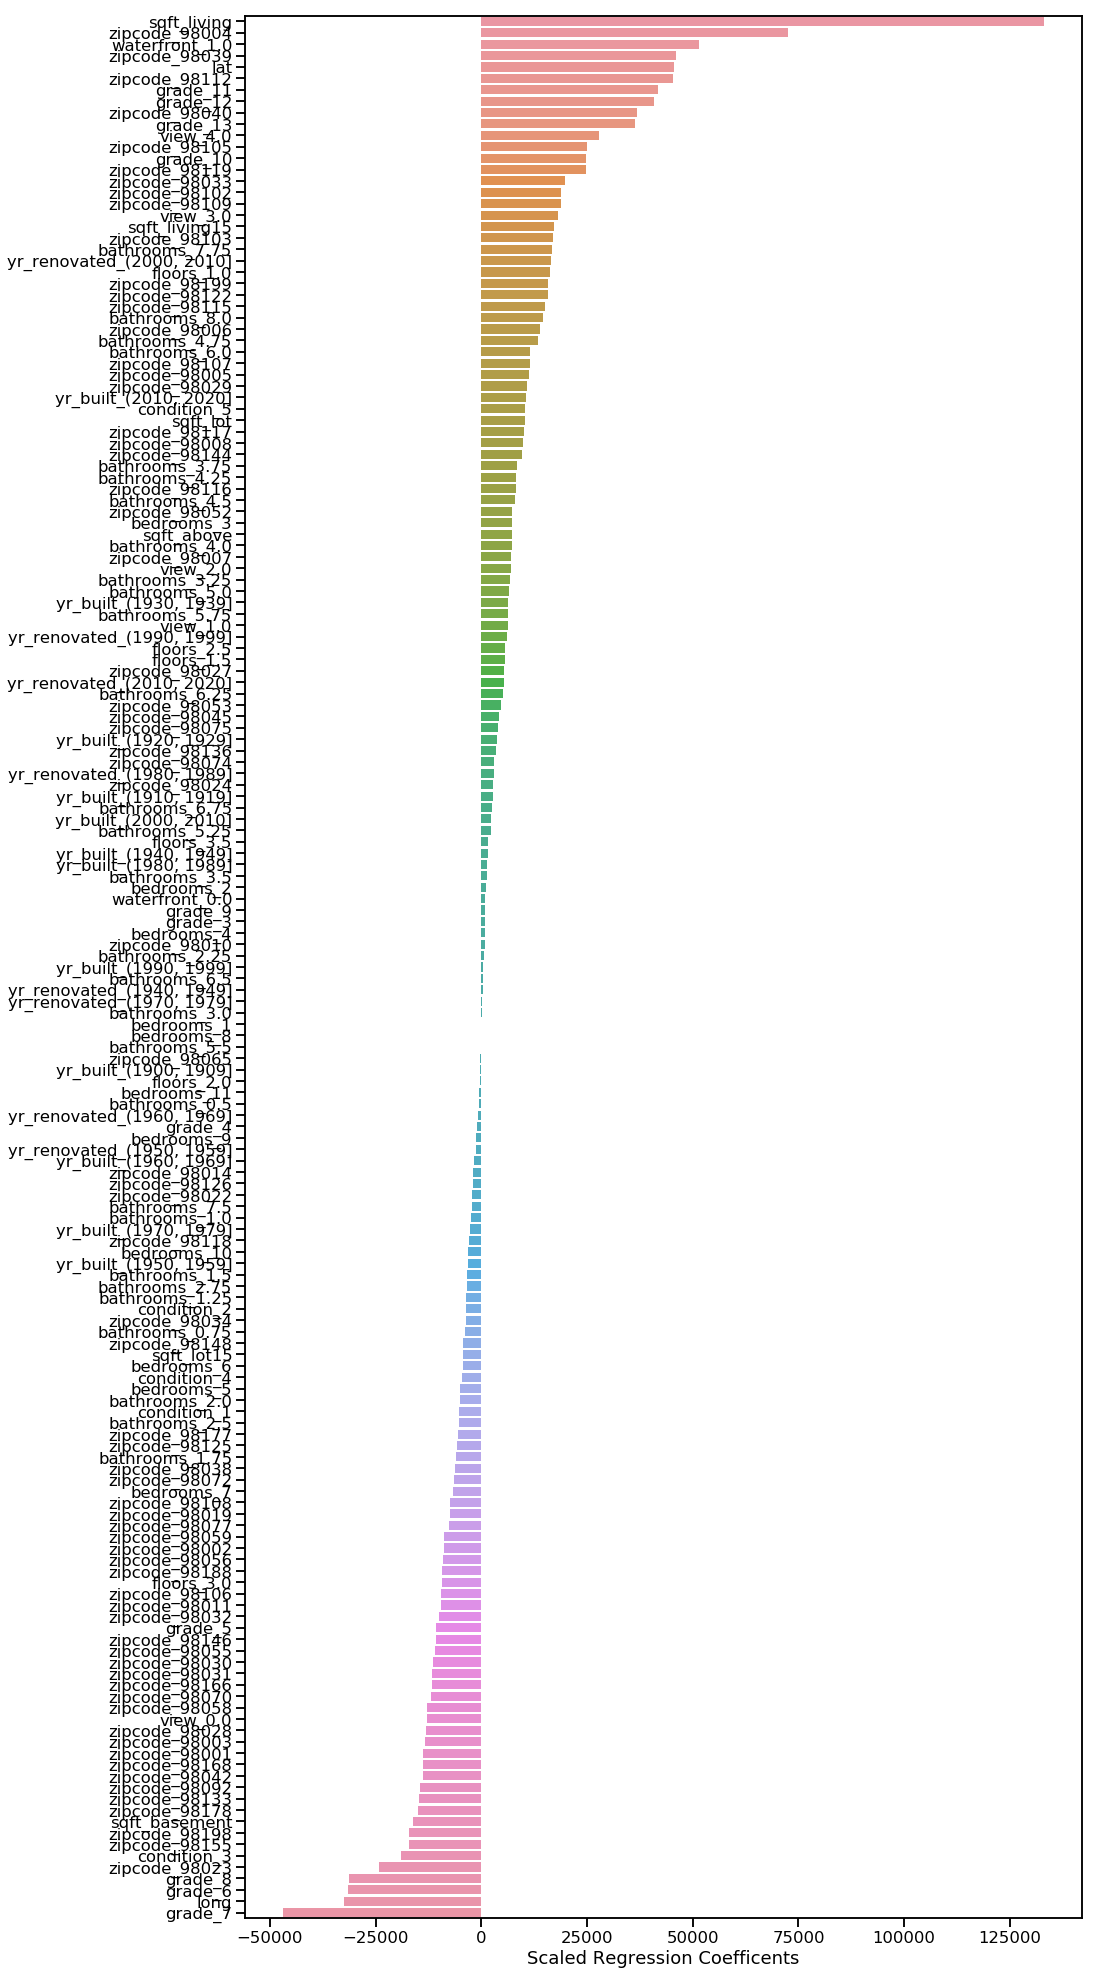

In [29]:
# Plot the coeffients
    
sns.set_context('talk')
fig = plt.figure(figsize=(15,35))
plt.tight_layout()

lasso_coef = lasso_coef[lasso_coef["penalized_coefficients"]!=0]
lasso_coef = lasso_coef.sort_values(by="penalized_coefficients", ascending=False)

ax = sns.barplot(x="penalized_coefficients", y=lasso_coef.index, data=lasso_coef)
ax.set(xlabel='Scaled Regression Coefficents')
fig.savefig("negative coefficients3", bbox_inches='tight')

In [30]:
# Plot the coeffients
    
# sns.set_context('talk')
# fig = plt.figure()
# plt.tight_layout()

# lasso_coef = lasso_coef[lasso_coef["penalized_coefficients"]!=0]
# lasso_coef = lasso_coef.sort_values(by="penalized_coefficients", ascending=False)[:9]

# ax = sns.barplot(x="penalized_coefficients", y=lasso_coef.index, data=lasso_coef)
# ax.set(xlabel='Scaled Regression Coefficents')
# ax.set_yticklabels(["View Rating 0", "Condition 3", "Zipcode 98198","Zipcode 98155","Building Grade 8", "Zipcode 98023", "Building Grade 6", "Longitude", "Building Grade 7"])
# fig.savefig("negative coefficients3", bbox_inches='tight')

In [ ]:
# lasso_coef = lasso_coef[lasso_coef["penalized_coefficients"]!=0]
# lasso_coef = lasso_coef.sort_values(by="penalized_coefficients", ascending=False)[:10]
# ax = sns.barplot(x="penalized_coefficients", y=lasso_coef.index, data=lasso_coef)
# ax.set(xlabel='Scaled Regression Coefficents')
# ax.set_yticklabels(["Square Feet Living", "Zipcode 98004", "Waterfront","Zipcode 98112","Latitude", "Zipcode 98039", "Building Grade 11", "Building Grade 12", "Zipcode 98040", "Grade 13"])
# fig.savefig("positive coefficients", bbox_inches='tight')